In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt 
import numpy as np

## Example

In [2]:
# class RBF(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
#     def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
#         self.length_scale = length_scale
#         self.length_scale_bounds = length_scale_bounds

#     @property
#     def anisotropic(self):
#         return np.iterable(self.length_scale) and len(self.length_scale) > 1

#     @property
#     def hyperparameter_length_scale(self):
#         if self.anisotropic:
#             return Hyperparameter(
#                 "length_scale",
#                 "numeric",
#                 self.length_scale_bounds,
#                 len(self.length_scale),
#             )
#         return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

#     def __call__(self, X, Y=None, eval_gradient=False):
#         """Return the kernel k(X, Y) and optionally its gradient.
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples_X, n_features)
#             Left argument of the returned kernel k(X, Y)
#         Y : ndarray of shape (n_samples_Y, n_features), default=None
#             Right argument of the returned kernel k(X, Y). If None, k(X, X)
#             if evaluated instead.
#         eval_gradient : bool, default=False
#             Determines whether the gradient with respect to the log of
#             the kernel hyperparameter is computed.
#             Only supported when Y is None.
#         Returns
#         -------
#         K : ndarray of shape (n_samples_X, n_samples_Y)
#             Kernel k(X, Y)
#         K_gradient : ndarray of shape (n_samples_X, n_samples_X, n_dims), \
#                 optional
#             The gradient of the kernel k(X, X) with respect to the log of the
#             hyperparameter of the kernel. Only returned when `eval_gradient`
#             is True.
#         """
#         X = np.atleast_2d(X)
#         length_scale = _check_length_scale(X, self.length_scale)
#         if Y is None:
#             dists = pdist(X / length_scale, metric="sqeuclidean")
#             K = np.exp(-0.5 * dists)
#             # convert from upper-triangular matrix to square matrix
#             K = squareform(K)
#             np.fill_diagonal(K, 1)
#         else:
#             if eval_gradient:
#                 raise ValueError("Gradient can only be evaluated when Y is None.")
#             dists = cdist(X / length_scale, Y / length_scale, metric="sqeuclidean")
#             K = np.exp(-0.5 * dists)

#         if eval_gradient:
#             if self.hyperparameter_length_scale.fixed:
#                 # Hyperparameter l kept fixed
#                 return K, np.empty((X.shape[0], X.shape[0], 0))
#             elif not self.anisotropic or length_scale.shape[0] == 1:
#                 K_gradient = (K * squareform(dists))[:, :, np.newaxis]
#                 return K, K_gradient
#             elif self.anisotropic:
#                 # We need to recompute the pairwise dimension-wise distances
#                 K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 / (
#                     length_scale ** 2
#                 )
#                 K_gradient *= K[..., np.newaxis]
#                 return K, K_gradient
#         else:
#             return K

#     def __repr__(self):
#         if self.anisotropic:
#             return "{0}(length_scale=[{1}])".format(
#                 self.__class__.__name__,
#                 ", ".join(map("{0:.3g}".format, self.length_scale)),
#             )
#         else:  # isotropic
#             return "{0}(length_scale={1:.3g})".format(
#                 self.__class__.__name__, np.ravel(self.length_scale)[0]
#             )


## NTK

In [33]:
class NTK(Kernel):
    def __init__(
        self, 
        depth, 
        # fixed_depth, 
        c=2.0):
        self.depth = depth
        # self.fixed_depth = fixed_depth
        self.c = c

    # Need's rewrite -> 2007.01580 uses x,z in R^d not whole matricies
    def __call__(self, X, Z=None, eval_gradient=False):
        

        # sigma_0(X,Z) = X @ Z.T -> usually vector x vector = scaler
        #                        -> but with n x m 



        if Z is None:
            Z = X
        # else:
            

        Σ = np.matmul(X, Z.T)
        print(X.shape, Z.shape, Σ.shape)
        Σ_dot = np.zeros_like(Σ)
        Θ = np.zeros((self.depth, X.shape[0], Z.shape[0]))
        Θ[0] = Σ

        D = np.sqrt(np.matmul(X, X.T) * np.matmul(Z, Z.T))
        
        for dep in range(1, self.depth):
            D = np.sqrt(np.matmul(X, X.T) * np.matmul(Z, Z.T))
            λ = np.clip(Σ / D, a_min = - 1, a_max = 1)
            Σ = (self.c/(2*np.pi)) * λ * (np.pi - np.arccos(λ) + np.sqrt(1 - λ**2)) * D
            Σ_dot = (self.c/(2*np.pi)) * (np.pi - np.arccos(λ))
            Θ[dep] = Θ[dep-1] * Σ_dot + Σ

        if eval_gradient:
            return Θ[self.depth-1], np.empty((X.shape[0], X.shape[0], 0))
        else:
            return Θ[self.depth-1]
        
        # return Θ

    def diag(self, X):
        return np.einsum("ij,ij->i", X, X)

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

    def __repr__(self):
        return "{0}(depth={1:3d}, c={2:.3f})".format(
                self.__class__.__name__, self.depth, self.c)

In [4]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    Σ = np.matmul(X, X.T)
    Σ_dot = np.zeros_like(Σ)
    for dep in range(d_max):
        if fix_dep <= dep:
            Σ_dot += Σ
        K[dep] = Σ_dot
        L = np.diag(Σ)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        λ = np.clip(Σ / P, a_min = -1, a_max = 1)
        Σ = (λ * (math.pi - np.arccos(λ)) + np.sqrt(1.0 - λ * λ)) * P / 2.0 / math.pi
        Σ_dot = Σ_dot * (math.pi - np.arccos(λ)) / 2.0 / math.pi
    return K[d_max - 1]

## Gaussian Process Practice

In [5]:
# Dataset
rng = np.random.RandomState(624562)
X = np.linspace(0, 10, 1000)
y = X * np.sin(X)

X = X.reshape((-1, 1))
y = y.reshape((-1, 1))

training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
x_train, y_train = X[training_indices], y[training_indices]
y_train_noisy = y_train + rng.normal(loc=0.0, scale=0.75, size=y_train.shape)

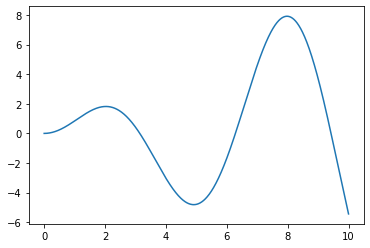

In [6]:
plt.plot(X,y)

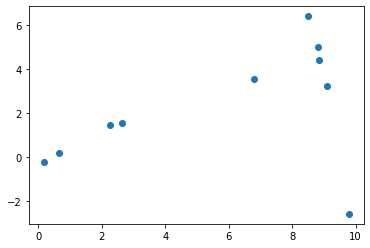

In [7]:
plt.scatter(x_train, y_train_noisy)

In [34]:
# kernel = 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.5)
# kernel = ConstantKernel() * RBF(1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(0.1, (1e-9, 1e5))
kernel = ConstantKernel() * NTK(depth=2, c=2.0) + WhiteKernel(0.1)
gp = GPR(kernel=kernel, n_restarts_optimizer=9)
gp.fit(x_train, y_train_noisy)
gp.kernel_

(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)


0.249**2 * NTK(depth=  2, c=2.000) + WhiteKernel(noise_level=6.15)

(10, 1) (10, 1) (10, 10)


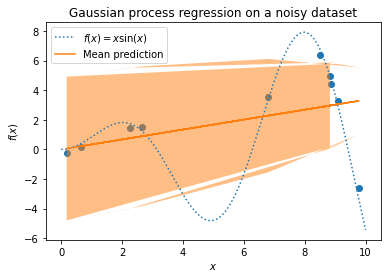

In [37]:
mean_pred, std_pred = gp.predict(x_train, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x=x_train.ravel(), y=y_train_noisy.ravel())
plt.plot(x_train, mean_pred, label="Mean prediction")
plt.fill_between(
    x_train.ravel(), 
    mean_pred.ravel() - 1.96*std_pred.ravel(), 
    mean_pred.ravel() + 1.96*std_pred.ravel(),
    alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [10]:
laplace_kernel = Matern(
    length_scale=1.0,
    length_scale_bounds=(1e-5, 1e5),
    nu=1/2
    )

